TODO:
try non trainable bert ?
absolute loss?
clip loss?
biased experience replay
write train class
save/write model
custom loss?
dropout?
batchnorm?
diff architecture?
steal bert calssifier https://www.tensorflow.org/text/tutorials/classify_text_with_bert


# Advanced Deep Learning for NLP - Text based adventure game RL


WIP: Links not assigned yet

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Google Colab stuff

In [1]:
%%capture
!pip install tf-agents
!pip install textworld

from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/MyDrive/DeepLearningNLP/")

Or alternatively (for future, when project not private anymore):

In [ ]:
!git clone https://github.com/

Cloning into 'github.com'...
fatal: repository 'https://github.com/' not found


## Imports

In [2]:
from tests import test_environment_creation
import train

%load_ext autoreload
%autoreload 2

## Generate games


Only run of necessary.

In [ ]:
os.chdir("/content/drive/MyDrive/DeepLearningNLP/scripts/")

In [ ]:
%%shell
bash ./make_debug_game.sh

Global seed: 2021
Game generated: /content/drive/My Drive/DeepLearningNLP/resources/game_th_lvl2_simple.ulx


In [ ]:
%%capture
%%shell
bash ./make_allgames.sh

In [ ]:
os.chdir("/content/drive/MyDrive/DeepLearningNLP/")

# Test environment

In [ ]:
test_environment_creation()

# Train

In [3]:
hp_dict = {
  "num_iterations": 1500,
  "learning_rate": 1e-3,
  "initial_collect_steps": 5000,
  "collect_steps_per_iteration": 1,
  "replay_buffer_max_length": 100000,
  "batch_size": 128,
  "log_interval": 250,
  "num_eval_episodes": 1,
  "eval_interval": 250,
  "game_gen_interval": 500,
  "game_gen_no": 50,
}
REWARD_DICT = {
    "win_lose_value": 100,
    "max_loop_pun": 1,
    "change_reward": 2,
    "useless_act_pun": 1,
    "verb_in_adm": 2,
}

Debug Start Filling RB
GAME WON
GAME WON
Debug End Filling RB
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 250: loss = 4430580.0
step = 250: Average Return = 3.0
step = 500: loss = 685481600.0
step = 500: Average Return = 3.0
GAME WON
GAME WON
GAME WON
GAME WON
step = 750: loss = 9356243968.0
step = 750: Average Return = -97.0
step = 1000: loss = 52037099520.0
step = 1000: Average Return = -97.0
step = 1250: loss = 194285174784.0
step = 1250: Average Return = -97.0
step = 1500: loss = 486452789248.0
step = 1500: Average Return = -97.0
(6,) [ 250  500  750 1000 1250 1500]
(6,) [  3.   3. -97. -97. -97. -97.]
[  3.   3. -97. -97. -97. -97.]


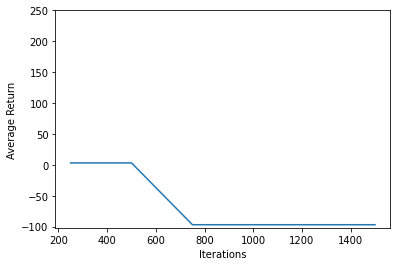

In [4]:
eval_scores = train.main(
    plot_avg_ret=True,
    debug=False,
    reward_dict=REWARD_DICT,
    env_dir="train_games_lvl2",
    **hp_dict
)
print(eval_scores)

## Hyper parameter search

In [ ]:
%%capture
!pip install optuna
import optuna

In [ ]:
def objective(trial):
    """"""

    hp_dict = {
      "num_iterations": 2000,
      "learning_rate": trial.suggest_loguniform("lr", 1e-4, 1e-2),
      "initial_collect_steps": 10000,
      "collect_steps_per_iteration": 1,
      "replay_buffer_max_length": 100000,
      "batch_size": trial.suggest_int("batch_size", 16, 256),
      "log_interval": 500,
      "num_eval_episodes": 1,
      "eval_interval": 100,
    }

    REWARD_DICT = {
        "win_lose_value": 100,
        "max_loop_pun": 1,
        "change_reward": 1,
        "useless_act_pun": 1,
        "verb_in_adm": 1,
    }

    eval_scores = train.main(plot_avg_ret=True, debug=False, reward_dict=REWARD_DICT, **hp_dict)
    # eval_scores = np.delete(eval_scores, 0)

    return max(eval_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print(study.best_trial)

In [ ]:
print(study.best_trial)

FrozenTrial(number=0, values=[203.0], datetime_start=datetime.datetime(2021, 7, 30, 11, 46, 26, 924586), datetime_complete=datetime.datetime(2021, 7, 30, 11, 50, 2, 140224), params={'lr': 0.004015582546958087, 'batch_size': 89}, distributions={'lr': LogUniformDistribution(high=0.01, low=0.0001), 'batch_size': IntUniformDistribution(high=256, low=16, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)
